# Title of the Journal...?

## Contents

1. [**Libraries and Preliminaries**](#Libraries-and-Preliminaries)
2. [**Image Preprocessing**](#Image-Preprocessing)
    1. [Normalizing and Chipping Sentinel-2 Images](#Normalize-the-Sentinel-2-Images)
    2. [Creating a Dataset of Chips](#Creating-a-Dataset-of-Chips)
3. [**Deep Learning - ResNet-50**](#Deep-Learning)
    1. [Passing Normalized Chips through the Network](#Passing-Normalized-Chips-through-the-Network)
    2. [Extracting ResNet-50 Features](#Extracting-ResNet-50-Features)
4. [**Features and a First Statistical Analysis**](#Features-and-a-First-Statistical-Analysis)
    1. [Feature Histograms](#Created-Histograms-for-the-2,048-Features-and-Saved-them-in-a-File)
    2. [Conducting KL-Divergence for all the Histograms Created](#Conducting-KL-Divergence-for-all-the-Histograms-Created)
5. [**Chip and Census Tract Polygons**](#Chip-and-Census-Tract-Polygons)
    1. [Extracting Longitude and Latitude from the jp2 Image](#Extracting-Longitude-and-Latitude-from-the-jp2-Image)
    2. [Joining the Census Tract Polygon and the Chips Polygon Tables](#Joining-the-Census-Tract-Polygon-and-the-Chips-Polygon-Tables)
    3. [Show the Census Tract Polygon (in Blue) and the Chips Polygon (in Green)](#Show-the-Census-Tract-Polygon-(in-Blue)-and-the-Chips-Polygon-(in-Green))
6. [**Machine Learning Analysis**](#Machine-Learning-Analysis)
    1. [Linear Regression](#Linear-Regression)
        1. [Linear Regression for all Features](#Linear-Regression-for-all-Features)
        2. [Linear Regression Scatter Plot for Testing](#Linear-Regression-Scatter-Plot-for-Testing)
        3. [Linear Regression for Scatter Plot for Training](#Linear-Regression-for-Scatter-Plot-for-Training)
    2. [Random Forest](#Random-Forest)
        1. [Random Forest for All Features](#Random-Forest-for-All-Features)
        2. [Random Forest Scatter Plot](#Random-Forest-Scatter-Plot)
        3. [Renamed the df to df_final](#Renamed-the-df-to-df_final)
    3. [Averaging Feature Vectors](#Averaging-Feature-Vectors)
        1. [Linear Regression for the Average Features Vectors for Each Census Tract](#Linear-Regression-for-the-Average-Features-Vectors-for-Each-Census-Tract)
        2. [Linear Regression for the Area Weighted Average for Each Census Tract](#Linear-Regression-for-the-Area-Weighted-Average-for-Each-Census-Tract)
        3. [The Average Features Vectors for Each Census Tract](#The-Average-Features-Vectors-for-Each-Census-Tract)
        4. [Linear Regression for the Average Features Vectors for Each Census Tract (All Features)](#Linear-Regression-for-the-Average-Features-Vectors-for-Each-Census-Tract-(All-Features))
        5. [Linear Regression for the Average Features Vectors for Each Census Tract (Selected Features)](#Linear-Regression-for-the-Average-Features-Vectors-for-Each-Census-Tract-(Selected-Features))    
    4. [Selecting "Best" Features](#Selecting-"Best"-Features)
        1. [Random Selection for the Average Features Vectors for Each Census Tract (All Features)](#Random-Selection-for-the-Average-Features-Vectors-for-Each-Census-Tract-(All-Features))
        2. [Random Selection for the Average Features Vectors for Each Census Tract (Selected Features)](#Random-Selection-for-the-Average-Features-Vectors-for-Each-Census-Tract-(Selected-Features))
        3. [The Area Weighted Average for Each Census Tract](#The-Area-Weighted-Average-for-Each-Census-Tract)
    5. [Regression with Best Weighted Features](#Regression-with-Best-Weighted-Features)
        1. [Linear Regression for the Area Weighted Average for Each Census Tract](#Linear-Regression-for-the-Area-Weighted-Average-for-Each-Census-Tract)
        2. [Random Forest for the Area Weighted Average for Each Census Tract](#Random-Forest-for-the-Area-Weighted-Average-for-Each-Census-Tract)

## 1 - Libraries and Preliminaries

In [3]:
import numpy as np
import glob
import tqdm
import rasterio as rio
import numpy as np
import os
import skimage.io as sio
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import time
import torch
import torchvision
from torchvision import transforms
import pandas as pd

%matplotlib inline
plt.style.use('fast')

In [4]:
DATA_DIR  = os.getenv('DATA_DIR') #set as environment variable
CHIP_DIR  = DATA_DIR + '/chips'
CHIP_SIZE = 224
CHIP_TEMP_RAM = '/ramdisk/chips
CHIP_TEMP_PVC = '/

blue_images  = sorted(glob.glob(DATA_DIR + '/*/T*B02*.jp2'))  # blue in any .SAFE dir
green_images = sorted(glob.glob(DATA_DIR + '/*/T*B03*.jp2'))  # green in any .SAFE dir
red_images   = sorted(glob.glob(DATA_DIR + '/*/T*B04*.jp2'))  # red in any .SAFE dir
all_bands    = blue_images + green_images + red_images
N            = len(all_bands)

## 2 - Image Preprocessing

### 2.A - Normalizing and Chipping Sentinel-2 Images

**Creating a Worker Function for Each Image**

In [5]:
def chip_and_normalize_band(input_path,index):

    #some feedback to know what's going on
    filename = input_path.split("/")[-1]
    print(f'[{index}/{N}] Processing {filename}')
    
    #input variables
    src        = rio.open(input_path,'r')
    raster_max = src.statistics(1).max
    raster_min = 0
    basename   = os.path.basename(input_path).split('.')[0]

    #output variables
    kwargs = src.meta.copy()
    kwargs.update({'driver':'GTiff','height':CHIP_SIZE,'width':CHIP_SIZE,'dtype':np.float32})

    # Get a list of windows in the raster to iterate through
    windows = []
    for i,x in enumerate(range(0,src.height-CHIP_SIZE,CHIP_SIZE)):
        for j,y in enumerate(range(0,src.width-CHIP_SIZE,CHIP_SIZE)):
            windows.append(((i,j),rio.windows.Window(col_off=y,row_off=x,width=CHIP_SIZE,height=CHIP_SIZE)))

    #read and normalize
    for (i,j),w in windows:
        chip = src.read(1,window=w)
        chip = (chip-raster_min)/(raster_max-raster_min) #Normalize to [0,1]

        #write to output file
        output_path = f"{CHIP_DIR}/{basename}_CHIP_{i:02d}_{j:02d}.tif"        
        with rio.open(output_path, 'w',**kwargs) as dst:
            dst.write(chip,indexes=1)
    
    #close and clean up
    src.close()
    if os.path.isfile(input_path+'.aux.xml'):
        os.remove(input_path+'.aux.xml')
        
    print(f'{filename} done ({index}).')
    return

**Give Each Thread a Copy of the Function**

In [6]:
#Make dir if not already there
if not os.path.isdir(CHIP_DIR):
    os.mkdir(CHIP_DIR)

#Set up number of worker threads based on nr of cpu's
if os.cpu_count() > 16:
    n_workers = 16
else:
    n_workers = os.cpu_count()

#Run
start_time = time.time()
with ThreadPoolExecutor(max_workers=n_workers) as executor: 
    executor.map(chip_and_normalize_band,all_bands,range(1,N+1))
end_time = time.time()
print(f"Execution time: {round(end_time-start_time,4)} seconds.") #<--- Should take about 700 seconds (11+ min)

[1/99] Processing T15SUD_20220710T165911_B02_10m.jp2[2/99] Processing T15TTF_20220713T170901_B02_10m.jp2

[3/99] Processing T15SYA_20220714T163911_B02_10m.jp2
[4/99] Processing T15SYB_20220714T163911_B02_10m.jp2
[5/99] Processing T15SYV_20220714T163911_B02_10m.jp2
[6/99] Processing T16SCF_20220714T163911_B02_10m.jp2
[7/99] Processing T15SVA_20220720T165901_B02_10m.jp2
[8/99] Processing T15SVC_20220720T165901_B02_10m.jp2
[9/99] Processing T15SVD_20220720T165901_B02_10m.jp2
[10/99] Processing T15TVE_20220720T165901_B02_10m.jp2
T15SVD_20220720T165901_B02_10m.jp2 done (9).
[11/99] Processing T15TWE_20220720T165901_B02_10m.jp2
T16SCF_20220714T163911_B02_10m.jp2 done (6).
[12/99] Processing T15TUE_20220723T170901_B02_10m.jp2
T15TTF_20220713T170901_B02_10m.jp2 done (2).
[13/99] Processing T15TUF_20220723T170901_B02_10m.jp2
T15SYB_20220714T163911_B02_10m.jp2 done (4).
[14/99] Processing T15SYC_20220813T163911_B02_10m.jp2
T15SUD_20220710T165911_B02_10m.jp2 done (1).
[15/99] Processing T16SCG_20

**Visualize an Example Chip**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16931817..1.420909].


./data/chips/T15SVC_20220720T165901_B02_10m_CHIP_30_30.tif


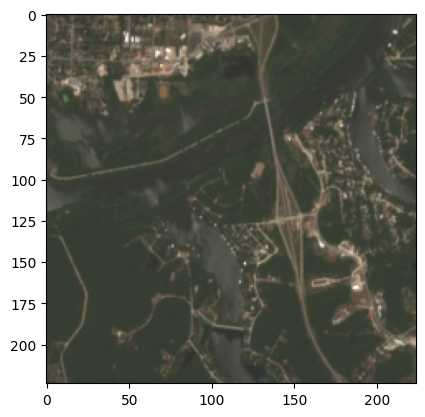

In [19]:
sample_nr   = 15906
sample_path_b = sorted(glob.glob(f'{CHIP_DIR}/*_B02_10m_CHIP_*_*.tif'))[sample_nr]
sample_path_g = sorted(glob.glob(f'{CHIP_DIR}/*_B03_10m_CHIP_*_*.tif'))[sample_nr]
sample_path_r = sorted(glob.glob(f'{CHIP_DIR}/*_B04_10m_CHIP_*_*.tif'))[sample_nr]
b = sio.imread(sample_path_b)
g = sio.imread(sample_path_g)
r = sio.imread(sample_path_r)
rgb = np.stack((r,g,b),axis=2)
print(sample_path_b)
plt.imshow(rgb*3)

## 3 - Deep Learning - Extracting ResNet-50 Features for Each Chip

In [66]:
# SET DEVICE
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps') #mac
else:
    device = torch.device('cpu')
print(f'Using {device} for inference')

Using mps for inference


### Creating a Dataset of Chips

In [20]:
class SentinelDataset(torch.utils.data.Dataset):
    def __init__(self,chips_path):
        self.images_b = sorted(glob.glob(f'{chips_path}/*_B02_10m_CHIP_*_*.tif'))
        self.images_g = sorted(glob.glob(f'{chips_path}/*_B03_10m_CHIP_*_*.tif'))
        self.images_r = sorted(glob.glob(f'{chips_path}/*_B04_10m_CHIP_*_*.tif'))
    
    def __getitem__(self, index):
        b = sio.imread(self.images_b[index])
        g = sio.imread(self.images_g[index])
        r = sio.imread(self.images_r[index])
        return torch.from_numpy(np.stack([r,g,b], axis=0))

    def __len__(self):
        return len(self.images_b)

In [21]:
dataset    = SentinelDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
#TEST READ SPEED OF DISK
pvc_path = '/obesity-images/chips'
ram_path = '/ramdisk/chips

dataset_0 = SentinelDataset(CHIP_DIR)
dataset_1 = SentinelDataset(ram_path)
dataset_2 = SentinelDataset(pvc_path)

dataloader_0 = torch.utils.data.DataLoader(dataset_0,batch_size=)

### Loading the Neural Network and Removing its Top Layer

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained = True,trust_repo=True,verbose=True,skip_validation=True)
resnet50.fc = torch.nn.Identity() # Remove final classification layer
resnet50 = resnet50.eval()
# resnet50 = resnet50.to(device)
# -------
# In case above model does not load, use torchvision resnet:
# resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
# resnet50.fc = torch.nn.Identity() # Remove final classification layer
# resnet50 = resnet50.eval()
# resnet50 = resnet50.to(device)

Using cache found in /Users/cimv/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/cimv/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/cimv/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


### Passing Normalized Chips through the Network

In [ ]:
FEATURES_CSV  = f'{DATA_DIR}/features.csv'
features_list = []

start_time = time.time()

with torch.no_grad():
    for _,x in tqdm.tqdm(enumerate(dataloader), total=(len(dataset))):
        x = x.to(device)
        y = resnet50(x)
        y = y.cpu().numpy()
        features_list.append(y)

stop_time  = time.time()
execution_time = stop_time - start_time
print(f"Execution time: {execution_time} seconds")

**Save Features to a File**

In [ ]:
#SAVE FEATURES TO DISK
np.savetxt(FEATURES_CSV,np.array(features_list),delimiter=',')

## 3 - Statistical Analysis for Features

In [ ]:
np_features = np.loadtxt(FEATURES_CSV,delimiter=',',type=float)
df_features = pd.read_csv(FEATURES_CSV)

In [ ]:
df_features

In [ ]:
# Assuming 'df_features' is our DataFrame with 2048 columns

# Calculate minimum for each column
min_values = np.min(df_features, axis=0)

# Calculate maximum for each column
max_values = np.max(df_features, axis=0)

# Calculate range (max - min) for each column
# range_values = np.ptp(df_features, axis=0)

# Create a DataFrame to store the results
summary_df_features = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    #'Range': range_values
})

# Print the summary DataFrame
print(summary_df_features)


## Statistical Analysis for Features

### Created Histograms for the 2,048 Features and Saved them in a File

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# bin_width = 0.05

# for i in range(2048):
#     feature_name = f'feature_{i}'
    
#     # Generate histogram
#     hist, bin_edges = np.histogram(df_features[feature_name], bins=int(1 / bin_width), range=(0, 1), density=True)
    
#     # Plot the histogram
#     plt.bar(bin_edges[:-1], hist, width=bin_width)
    
#     plt.title(f'Histogram of {feature_name}')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')

#     # Define a file name to save the histogram
#     file_name = f'histogram_{i}.png'
    
#     if i < 3:
#         plt.show() 

#     # Save the histogram to a file (e.g., as a PNG image)
#     plt.savefig(f'histograms/histogram_{feature_name}.png')
    
#     # Clear the current plot for the next iteration
#     plt.clf()

#     print(f'Saved histogram for {feature_name} as {file_name}')


In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt

#bin_width = 0.05

#for i in range(2048):
    #feature_name = f'feature_{i+1}'  # Assuming feature names are like feature_1, feature_2, ...
    
    # Calculate the histogram
    #hist, edges = np.histogram(df_features[feature_name], bins=int(1 / bin_width), range=(0, 1), density=True)
    
    # Plot the histogram
    #plt.bar(edges[:-1], hist, width=bin_width)
    
    #plt.title(f'Histogram of {feature_name}')
    #plt.xlabel('Value')
    #plt.ylabel('Frequency')
    
    # Define a file name to save the histogram
    #file_name = f'histogram_{i+1}.png'
    
    # Save the histogram to a file
    #plt.savefig(file_name)
    
    # Clear the current plot for the next iteration
    #plt.clf()

    #print(f'Saved histogram for {feature_name} as {file_name}')


## Conducting KL-Divergence for all the Histograms Created

In [ ]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL divergences
kl_divergences = []

for i in tqdm.tqdm(range(2048)):
    for j in range(i+1, 2048):
        
        hist_i, _ = np.histogram(df_features[f'feature_{i}'], bins=np.linspace(0, 5, 500))
        hist_j, _ = np.histogram(df_features[f'feature_{j}'], bins=np.linspace(0, 5, 500))

        kl_value = kl_divergence(hist_i, hist_j)
        
        kl_divergences.append((i, j, kl_value))

# Sort the list of KL divergences
kl_divergences.sort(key=lambda x: x[2])

# Print the top 10 pairs with the smallest KL divergences
for i, j, kl_value in kl_divergences[:10]:
    print(f'KL Divergence between feature_{i} and feature_{j}: {kl_value}')



In [ ]:
df_features.shape

## Chip and Census Tract Polygons

### Extracting Longitude and Latitude from the jp2 Image

In [ ]:
df_features.columns = ['file', *df_features.columns[1:]]
def get_original_jp2(chip):
    return chip.replace('/home/jovyan/output_images_all/', '/data/obesity-images/all/').split('_normalized')[0] + '.jp2'
df_features['jp2'] = df_features['file'].apply(get_original_jp2)

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import functools

@functools.lru_cache(None)
def get_coords(jp2_file_path):
    # jp2_file_path = '/data/JAMIA/T15SWD_20230829T165849_B02_10m.jp2'
    with rasterio.open(jp2_file_path) as dataset:
        # Assuming the image is georeferenced, this will get the bounds
        bounds = dataset.bounds
        x1, y1, x2, y2 = bounds.left, bounds.top, bounds.right, bounds.bottom
        w, h = dataset.width, dataset.height
    return x1, y1, x2, y2, w, h


In [ ]:
x1, y1, x2, y2, w, h = get_coords('/data/JAMIA/T15SWD_20230829T165849_B02_10m.jp2')

In [ ]:
df_features['image_coords'] = df_features['jp2'].apply(get_coords)

In [ ]:
!ln /data/obesity-images/*/*.jp2 /data/obesity-images/all

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from pyproj import Transformer

# Define transformer to convert from UTM zone 15N to WGS 84
transformer = Transformer.from_crs(dataset.crs, "epsg:4326", always_xy=True)

# jp2_file_path = '/data/JAMIA/T15SWD_20230829T165849_B02_10m.jp2'

# with rasterio.open(jp2_file_path) as dataset:
#     # Assuming the image is georeferenced, this will get the bounds
#     bounds = dataset.bounds
#     x1, y1, x2, y2 = bounds.left, bounds.top, bounds.right, bounds.bottom
#     w, h = dataset.width, dataset.height


# Modify the get_lat_lon function to return a Polygon
def get_lat_lon(f):
    jp2 = get_original_jp2(f)
    x1, y1, x2, y2, w, h = get_coords(jp2)

    resolution_x = (x2 - x1) / w
    resolution_y = (y2 - y1) / h

    x, y = f[-15:-4].split('_')
    x, y = int(x), int(y)
    lon1 = x1 + resolution_x * x
    lat1 = y1 + resolution_y * y
    lon2 = lon1 + 224 * resolution_x
    lat2 = lat1 + 224 * resolution_y
    
    # Transform the coordinates
    lon1, lat1 = transformer.transform(lon1, lat1)
    lon2, lat2 = transformer.transform(lon2, lat2)

    # Create a Polygon object
    return Polygon([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)])

# Apply the function to the 'file' column
df_features['geometry'] = df_features.iloc[:, 0].apply(get_lat_lon, )

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_features, geometry='geometry')

gdf.to_csv('chips-features-polygons.csv')

# Example usage
gdf.head()

In [ ]:
gdf = pd.read_csv('chips-features-polygons.csv')

# Example usage
gdf.head()

In [ ]:
from shapely import wkt
import geopandas as gpd

obesity_df = pd.read_csv('final-original.csv')
obesity_df.index = obesity_df['Unnamed: 0']
obesity_df = obesity_df.drop('Unnamed: 0', axis=1)

def maybe_wkt_load(inp):
    try:
        return wkt.loads(inp)
    except Exception:
        # print('failed')
        return None
# obesity_df['geometry'] = obesity_df['geometry'].apply(maybe_wkt_load)
obesity_df['geometry'] = obesity_df['geometry'].apply(wkt.loads) 
obesity_gdf = gpd.GeoDataFrame(obesity_df, crs='epsg:4326') 


In [ ]:
obesity_gdf.plot()

In [ ]:
obesity_gdf = obesity_gdf[obesity_gdf['geometry'].apply(lambda x: x is not None)] 

In [ ]:
obesity_gdf.shape

In [ ]:
# Features per chip polygon

gdf.head()

In [ ]:
obesity_gdf.crs

In [ ]:
obesity_gdf_4 = obesity_gdf.to_crs(epsg='26915')
obesity_gdf_4["area"] = obesity_gdf_4["geometry"].area / 1000000
obesity_gdf_4.head()

In [ ]:
obesity_gdf_4.reset_index(inplace=True)
obesity_gdf_4.head()

In [ ]:
# obesity_gdf_5 = obesity_gdf_4[obesity_gdf_4["CountyName"] == "Boone"]
# obesity_gdf_5.head()

In [ ]:
obs_area = obesity_gdf_4[["GEOID", "TotalPopulation", "area", "OBESITY_CrudePrev"]]
#obs_area = obs_area[obs_area["CountyName"] == "Boone"]
obs_area.head()

In [ ]:
obesity_gdf

In [ ]:
# Obesity rates per census tract polygon

obesity_gdf[['OBESITY_CrudePrev', 'geometry', 'GEOID']]

In [ ]:
# Obesity rates per census tract polygon

obesity_gdf[['OBESITY_CrudePrev', 'geometry', 'GEOID']]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# obesity_gdf.plot('GEOID')

fig, ax = plt.subplots(1, 1)
obesity_gdf.plot(column='OBESITY_CrudePrev', ax=ax, legend=True)

ax.set_xlabel('Polygon Geometry')
ax.set_ylabel('Obesity Rate') 

ax.set_title('Obesity Rates per Census Tract Polygon')

plt.show()


In [ ]:

fig, ax = plt.subplots(1, 1)
obesity_gdf.plot(column='OBESITY_CrudePrev', ax=ax, legend=True, cmap="Reds")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# legend = ax.get_legend()
# legend.set_title('Obesity per 100k')
# ax.set_title(label='Obesity Rate per 100k')

# ax.set_title('Obesity Rates per Census Tract Polygon') # Census Tract-wise Obesity Rates in Missouri 
ax.set_title('Census Tract-wise Obesity Rates in Missouri (2022)') 
plt.show()

In [ ]:

fig, ax = plt.subplots(1, 1)
obesity_gdf.plot(column='OBESITY_CrudePrev', ax=ax, legend=True, cmap="Reds")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# legend = ax.get_legend()
# legend.set_title('Obesity per 100k')
# ax.set_title(label='Obesity Rate per 100k')

# ax.set_title('Obesity Rates per Census Tract Polygon') # Census Tract-wise Obesity Rates in Missouri 
# ax.set_title('Census Tract-wise Obesity Rates in Missouri (2022)') 
plt.show()

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(7,3.5))
obesity_gdf.plot(ax=ax[0], legend=True, cmap="Reds")
obesity_gdf.plot(ax=ax[1], column='OBESITY_CrudePrev', legend=True, cmap="Reds")

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# ax.set_title('Obesity Rates per Census Tract Polygon')

plt.show()

# Joining the Census Tract Polygon and the Chips Polygon Tables

In [ ]:
# Left spatial join

obesity_gdf['OBESITY_CrudePrev'] = obesity_gdf['OBESITY_CrudePrev'].apply(float)
joined_gdf = gpd.sjoin(gdf, obesity_gdf[['OBESITY_CrudePrev', 'geometry', 'GEOID']], how='left', predicate='intersects',)
# joined_gdf[['file', 'OBESITY_CrudePrev']].groupby('file').mean()

joined_gdf

In [ ]:
# Save the joined gdf as csv file

joined_gdf.to_csv('all_joined_gdf.csv')

In [ ]:
joined_gdf = pd.read_csv('all_joined_gdf.csv')

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf.plot(alpha=0.1, ax=ax)
gdf.plot(ax=ax, facecolor='green')

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude')

ax.set_title('Sentinel-2 Image within Missouri')

plt.show()

# ax.equal_axis(True)
# plt.ylim(39.6, 39.7)
# plt.xlim(-93.0, -92.8)

In [ ]:
joined_gdf = joined_gdf.sort_values('file')

In [ ]:
joined_gdf[[
    'GEOID', 'index_right'
]].groupby('GEOID').count().to_csv('num_chips_per_ct.csv')

In [ ]:
# joined_gdf.groupby('GEOID').count()

In [ ]:
# The chip with the most intersections
joined_gdf_1 = joined_gdf[joined_gdf['file'] == '/home/jovyan/output_images_all/T15SUD_20220710T165911_B04_10m_normalized_chip_06272_07392.tif']
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf.loc[joined_gdf_1['index_right'].values].plot('OBESITY_CrudePrev', cmap='jet', ax=ax, legend=True)
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='w')

ax.set_title(f'Average {joined_gdf_1["OBESITY_CrudePrev"].mean():.2f}')


In [ ]:
obesity_gdf

In [ ]:
IDX = 30 # 608
joined_gdf_1 = joined_gdf[joined_gdf['index_right'] == IDX]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf[obesity_gdf.index == IDX].plot(ax=ax, legend=True, facecolor='none', edgecolor='b')
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='g')
ax.set_title(f'Average {joined_gdf_1["OBESITY_CrudePrev"].mean():.2f}')

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude')

ax.set_title(f'Number of Image Chips Intersecting with Census Tract ({joined_gdf_1.shape[0]} chips)' )

plt.show()



In [ ]:
joined_gdf_1 = joined_gdf[
    joined_gdf['file'] == '/home/jovyan/output_images_all/T15SUD_20220710T165911_B04_10m_normalized_chip_06272_07392.tif']
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf_1 = obesity_gdf.loc[joined_gdf_1['index_right'].values]
obesity_gdf_1["GEOID"] = obesity_gdf_1["GEOID"].astype('str') 
obesity_gdf_1["tractID"] = obesity_gdf_1["GEOID"].str[-6:-2] #Change the range whatever you want 

obesity_gdf_1.plot(ax=ax, legend=True, facecolor='none', edgecolor='b')
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='g')
ax.set_title(f'Average {joined_gdf_1["OBESITY_CrudePrev"].mean():.2f}')

for idx, row in obesity_gdf_1.iterrows():
    # Assuming the geometries are Point. For other types, you might need to adjust this.
    if row.geometry.type == 'Point':
        plt.annotate(row['GEOID'], xy=(row.geometry.x, row.geometry.y),
                     horizontalalignment='center')
    # For Polygon geometries, you might use the centroid or another representative point
    elif row.geometry.type == 'Polygon':
        plt.annotate(row['tractID'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center')


ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude')
plt.show()


In [ ]:
obesity_gdf_1.dtypes

In [ ]:
obesity_gdf_1["GEOID"] = obesity_gdf_1["GEOID"].astype('str') 
obesity_gdf_1["tractID"] = obesity_gdf_1["GEOID"].str[-6:-2]
#obesity_gdf_1["area"] = obesity_gdf_1["geometry"].area
obesity_gdf_1.head()

In [ ]:
# obesity_gdf_2 = obesity_gdf_1.to_crs(epsg='26915').reset_index()
# obesity_gdf_2["area"] = obesity_gdf_2["geometry"].area/1000000
# obesity_gdf_2.head()

In [ ]:
# obs_area = obesity_gdf_2[["GEOID", "TotalPopulation", "area", "OBESITY_CrudePrev"]]
# obs_area.head()

In [ ]:
obs_area.shape

In [ ]:
# The chip with the most intersections
# joined_gdf_1 = joined_gdf[joined_gdf['Unnamed: 0']]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

gdf.iloc[::5].plot(ax=ax, legend=True)
# joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='w')

ax.set_title(f'Average {joined_gdf_1["OBESITY_CrudePrev"].mean():.2f}')

# Show the Census Tract Polygon (in Blue) and the Chips Polygon (in Green)

In [ ]:
# chip = gdf['Unnamed: 0'][0]
def getxy(chip):
    x, y = chip[-15:-4].split('_')
    x, y = int(x), int(y)
    return x, y

def getx(chip):
    return getxy(chip)[0]

def gety(chip):
    return getxy(chip)[1]

gdf['x'] = gdf['file'].apply(getx)
gdf['y'] = gdf['file'].apply(gety)


In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
%matplotlib inline

In [ ]:
1

In [ ]:
gdf_10 = gdf[(gdf['x'] % 1 == 0) * (gdf['y'] % 1 == 0)]
# gdf_10.plot()

# for tile in :
joined_gdf_1 = joined_gdf[joined_gdf['file'].isin(gdf_10['file'].values)]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x1, x2 = -92.4, -92
y1, y2 = 38.85, 39.25
# ax.set_xlim(x1, x2)
# ax.set_ylim(y1, y2)
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='g')
obesity_gdf.loc[joined_gdf_1['index_right'].dropna().values].plot(
    ax=ax, legend=True, facecolor='none', edgecolor='b')
ax.plot([x1, x2, x2, x1, x1], [y2, y2, y1, y1, y2], c='r')
# ax.set_aspect('equal', adjustable='box')


In [ ]:
gdf_10 = gdf[(gdf['x'] < 2500) * (gdf['y'] < 2500)]
# gdf_10.plot()

# for tile in :
joined_gdf_1 = joined_gdf[joined_gdf['file'].isin(gdf_10['file'].values)]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf.loc[joined_gdf_1['index_right'].dropna().values].plot(
    ax=ax, legend=True, facecolor='none', edgecolor='b')
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='g')


In [ ]:
joined_gdf_1['index_right'].dropna().

In [ ]:
gdf_10 = gdf#[(gdf['x'] < 2500) * (gdf['y'] < 2500)]
# gdf_10.plot()

# for tile in :
joined_gdf_1 = joined_gdf[joined_gdf['file'].isin(gdf_10['file'].values)]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_aspect('equal', adjustable='box')

obesity_gdf.loc[joined_gdf_1['index_right'].dropna().values].plot(
    ax=ax, legend=True, facecolor='none', edgecolor='b')
joined_gdf_1.plot(ax=ax, facecolor='none', edgecolor='g')


ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude')

ax.set_title('Image Chips Intersecting with each Census Tract')
plt.show()

# Most updated data

In [ ]:
joined_gdf.dropna().to_csv('Data.csv', index=False)

## Machine Learning Analysis

### Linear Regression for all Features 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Load the CSV file
file_path = 'all_joined_gdf.csv'  # Replace it with our file path
data = pd.read_csv(file_path).dropna()

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
# selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)


#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
# 5-fold cross validation
data.dropna().shape

In [ ]:
X_selected

### Linear Regression Scatter Plot for Testing 

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

### Linear Regression for Scatter Plot for Training 

In [ ]:
import matplotlib.pyplot as plt

y_pred_sel = model_sel.predict(X_train_sel)

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()


### Random Forest for All Features 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Load the CSV file
file_path = 'joined_gdf.csv'  # Replace it with our file path
data = pd.read_csv(file_path)

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
# selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = RandomForestRegressor(n_jobs=-1, verbose=2)
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
# Extracting feature importances from the model
feature_importances = model_sel.feature_importances_

# Creating a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': feature_importances
})

# Sorting the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
features_df.head(10) 

In [ ]:
features_df[:10].plot.bar(y='Importance') 

In [ ]:
# Extracting feature importances from the model
feature_importances = model_sel.feature_importances_

# Creating a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': feature_importances
})

# Sorting the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
features_df.tail(10) 

In [ ]:
features_df[-10:].plot.bar(x='Feature', y='Importance')

In [ ]:
import geopandas as gpd
from shapely.wkt import loads

gdf = gpd.GeoDataFrame(data, geometry=data['geometry'].apply(loads)) 
# gdf.plot(column="feature_1112");
gdf.plot();


### Random Forest Scatter Plot 

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

## Rename and save the df to df_final 

In [ ]:
import pandas as pd

# Read the CSV file
file_path = 'all_joined_gdf.csv'  # Replace it with the path to our CSV file
df = pd.read_csv(file_path)

df.to_csv('df_final.csv')


## Number of Image Chips that Intersect with Each Census Tract

In [ ]:
df_counts['file']

In [ ]:
import matplotlib.pyplot as plt

df_counts = df.drop(['geometry', 'Unnamed: 0'], axis=1).groupby('GEOID').count()
df_counts['file'].hist()
plt.xlabel('Number of chips per census tract')
plt.ylabel('Frequency')

## The Average Features Vectors for Each Census Tract

In [ ]:
ct_stats = pd.read_csv('/data/JAMIA/JAMIA_Obs_CT_final.csv', encoding='utf-8')
ct_stats[['polygon_nr','CountyName','TotalPopulation','OBESITY_CrudePrev','TractFIPS','GEOID','geometry']]

In [ ]:
from shapely.wkt import loads

# ct_stats = pd.read_csv('/data/JAMIA/obs_area_pop_final.csv')
# ct_stats = pd.read_csv('/data/JAMIA/JAMIA_Obs_CT_final.csv')
# ct_stats.index = ct_stats['GEOID']

ct_stats = obesity_gdf

ct_stats = ct_stats.to_crs(epsg='26915').reset_index()
ct_stats["area"] = ct_stats["geometry"].area/1000000
ct_stats.head()

# Convert the 'geometry' column from WKT format to Shapely geometries
# ct_stats = gpd.GeoDataFrame(ct_stats, geometry=df['geometry'].apply(loads))
# Calculate the area for each row
# ct_stats['area'] = ct_stats['geometry'].area


fig, axs = plt.subplots(1, 3, figsize=(9, 3))

ct_stats['TotalPopulation'].hist(ax=axs[0])
ct_stats['area'].hist(ax=axs[1])
ct_stats['OBESITY_CrudePrev'].hist(ax=axs[2])

# titles
axs[0].set_title('Total population')
axs[1].set_title('Area')
axs[2].set_title('Obesity Rate [%]')

axs[0].set_ylabel('Count')

In [ ]:
ct_stats

In [ ]:
ct_stats.index = ct_stats['GEOID']
ct_stats = ct_stats.drop('Unnamed: 0', axis=1)
ct_stats

In [ ]:
ct_stats['#chips'] = df.groupby('GEOID').size() 

In [ ]:
ct_stats.describe().T.to_csv('cencus_tract_stats.csv') 

In [ ]:
# Calculate mean and standard deviation for each column of interest
plt.style.use('ggplot')

mean_total_population = ct_stats['TotalPopulation'].mean()
std_total_population = ct_stats['TotalPopulation'].std()

mean_area = ct_stats['area'].mean()
std_area = ct_stats['area'].std()

mean_obesity_rate = ct_stats['OBESITY_CrudePrev'].mean()
std_obesity_rate = ct_stats['OBESITY_CrudePrev'].std()

# Plotting the histograms and annotating them with mean and standard deviation
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Histogram for Total Population
ct_stats['TotalPopulation'].hist(ax=axs[0], color='C1')
axs[0].set_title('Total Population')
axs[0].set_ylabel('Count')
axs[0].annotate(f'Mean: {mean_total_population:.1f}\nSD: {std_total_population:.1f}', 
                xy=(0.35, 0.83), xycoords='axes fraction', 
                bbox=dict(boxstyle="round", fc="white"))

# Histogram for Area
ct_stats['area'].hist(ax=axs[1], color='C1')
axs[1].set_title('Area')
axs[1].annotate(f'Mean: {mean_area:.1f}\nSD: {std_area:.1f}', 
                xy=(0.35, 0.83), xycoords='axes fraction', 
                bbox=dict(boxstyle="round", fc="white"))

ct_stats['OBESITY_CrudePrev'].hist(ax=axs[2], color='C1')
axs[2].set_title('Obesity Rate [%]')
axs[2].annotate(f'Mean: {mean_obesity_rate:.1f}\nSD: {std_obesity_rate:.1f}', 
                xy=(0.05, 0.83), xycoords='axes fraction', 
                bbox=dict(boxstyle="round", fc="white"))

fig.savefig('ct_stats.pdf')

In [ ]:
df.head()

In [ ]:
df['image_coords']

In [ ]:
df_average = df.dropna().drop(['Unnamed: 0', 'geometry', 'file', 'jp2', 'image_coords'], axis=1).groupby('index_right').mean()
df_average = df_average.reset_index()
df_obs_2 = df_average[["GEOID"]]
df_obs_2["GEOID"] = df_obs_2["GEOID"].astype('int64')
df_obs_2.head() 

In [ ]:
# df_obs_2.shape

In [ ]:
obs_ar_pop = pd.merge(df_obs_2, obs_area, on='GEOID', how='left')
obs_ar_pop.head()

In [ ]:
obs_ar_pop.shape

In [ ]:
obs_ar_pop.to_csv("obs_area_pop_final.csv", index=False)

In [ ]:
df_average.shape

In [ ]:
df_average.to_csv('df_average.csv')

In [ ]:
# Generate the list of column names to drop
columns_to_drop = [f'feature_{i}' for i in range(0, 2048)]

# Drop the columns from the DataFrame
df_average.drop(columns=columns_to_drop)

### Linear Regression for the Average Features Vectors for Each Census Tract (All Features)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = Ridge()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

# 10-Fold Cross Validation

In [ ]:
plt.style.use('default')

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the CSV file
# file_path = 'joined_gdf.csv'  # Replace it with your file path
data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.6].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]


# Preparing the selected features and target variable for the model
X = X_selected
y = data['OBESITY_CrudePrev']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Prepare a DataFrame to store the metrics for each fold
metrics_df = pd.DataFrame(columns=['Fold', 'MSE', 'R2', 'Adjusted R2'])

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and fit the model
    # model = LinearRegression()
    # Why use ridge regression: Better for situations with multicollinearity, when preventing 
    # overfitting is important.

    model = Ridge(alpha=1.0)  # You can adjust alpha to fine-tune the regularization strength
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Adjusted R2
    n = X_test.shape[0]  # Number of observations in the test set
    p = 1 #X_test.shape[1]  # Number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Append to DataFrame
    print(mse)
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Fold': [fold], 'MSE': [mse], 'R2': [r2], 'Adjusted R2': [adj_r2]})])

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)  # Scatter plot of actual vs predicted values
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
    plt.xlabel('Actual Obesity Rates')
    plt.ylabel('Predicted Obesity Rates')
    plt.title(f'Actual vs Predicted Obesity Rates fold {fold}')
    plt.show()
mean_row = metrics_df.mean()
mean_row['Fold'] = 'Mean'
mean_row = pd.DataFrame(mean_row).T
# Display the table
pd.concat([metrics_df, mean_row])

In [ ]:
pd.DataFrame(mean_row).T

## General Linear Regression for Full Data

In [ ]:
data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Creating and fitting the linear regression model on the selected features
model_sel = Ridge()
model_sel.fit(X_selected, y)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_selected)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y, y_pred_sel)
r2_sel = r2_score(y, y_pred_sel)

# Calculate the adjusted R-squared
n = X_selected.shape[0]  # Number of observations
p = 1  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y.max()], [y.min(), y.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

In [ ]:
data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')#[selected_features]
y = data['OBESITY_CrudePrev']

# Creating and fitting the linear regression model on the selected features
model_sel = Ridge()
model_sel.fit(X_selected, y)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_selected)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y, y_pred_sel)
r2_sel = r2_score(y, y_pred_sel)

# Calculate the adjusted R-squared
# n = X_selected.shape[0]  # Number of observations
# p = X_selected.shape[1]  # Number of predictions
# adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

n = X_selected.shape[0]  # Number of observations
p = 1#X_test.shape[1]  # Number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

#print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2)

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y.max()], [y.min(), y.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data[selected_features]  # Use only selected features
y = data['OBESITY_CrudePrev']

# Creating and fitting the linear regression model on the selected features
model_sel = Ridge()
model_sel.fit(X_selected, y)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_selected)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y, y_pred_sel)
r2_sel = r2_score(y, y_pred_sel)

# Calculate the adjusted R-squared
n = X_selected.shape[0]  # Number of observations
# p = X_selected.shape[1]  # Number of selected features
# adj_r2_sel = 1 - (1 - r2_sel) * (n - 1) / (n - p - 1)

p = 1 #X_test.shape[1]  # Number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_sel, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Assuming y is your actual values and y_pred_sel is your predicted values from the model
r2_sel = r2_score(y, y_pred_sel)

print("R-squared:", r2_sel)


### Linear Regression for the Average Features Vectors for Each Census Tract (Selected Features)

In [ ]:
data = df_average

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^feature_')[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

<h1 style="color: red">The Area Weighted Average for Each Census Tract</h1>

In [ ]:
gdf

In [ ]:
from shapely.wkt import loads

# Convert the 'geometry' column from WKT format to Shapely geometries
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'].apply(loads)) 

# Calculate the area for each row
gdf['area'] = gdf['geometry'].area

# Add weighted features
gdf = pd.concat([gdf, gdf.iloc[:, 2:2+2048].multiply(gdf.area, axis=0).add_prefix('weighted_')], axis=1)

# Get the obesity rate per census tract/GEOID
obesity_rates_per_census_tract = gdf[['GEOID', 'OBESITY_CrudePrev']].groupby('GEOID').mean()

# Aggregate weighted features based on GEOID
columns = ['GEOID', 'area'] + [f'weighted_feature_{i}' for i in range(2048)]
weighted_features_per_census_tract = gdf[columns].groupby('GEOID').sum()
weighted_features_per_census_tract = weighted_features_per_census_tract.divide(
    weighted_features_per_census_tract.area, axis=0)
weighted_features_per_census_tract = weighted_features_per_census_tract.drop('area', axis=1)

# Add obesity_rate
weighted_features_per_census_tract = pd.concat([
    obesity_rates_per_census_tract, weighted_features_per_census_tract], axis=1)
weighted_features_per_census_tract

In [ ]:
import pandas as pd

weighted_features_per_census_tract.to_csv('weighted_features_per_census_tract.csv')


In [ ]:
weighted_features_per_census_tract = pd.read_csv('weighted_features_per_census_tract.csv')

In [ ]:
data = weighted_features_per_census_tract

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^weighted_feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^weighted_feature_')[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = 1 #X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

# print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show()

In [ ]:
data = weighted_features_per_census_tract

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^weighted_feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^weighted_feature_')[selected_features]
y = data['OBESITY_CrudePrev']

# Splitting the data into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Creating and fitting the linear regression model on the selected features
model_sel = RandomForestRegressor()
model_sel.fit(X_train_sel, y_train)

# Making predictions on the test set
y_pred_sel = model_sel.predict(X_test_sel)

# Evaluating the model on selected features
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

# Calculate the adjusted R-squared
n = X_test_sel.shape[0]  # Number of observations
p = 1 #X_test_sel.shape[1]  # Number of predictions
adj_r2_sel = 1 - (1-r2_sel) * (n-1) / (n-p-1)

# print("Selected Features:", selected_features)
print("Mean Squared Error:", mse_sel)
print("R-squared:", r2_sel)
print("Adjusted R-squared:", adj_r2_sel)


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_sel are already defined as our test target values and model predictions respectively
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sel, alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
plt.xlabel('Actual Obesity Rates')
plt.ylabel('Predicted Obesity Rates')
plt.title('Actual vs Predicted Obesity Rates')
plt.show() 

# Weighted average 10-fold cross validation

In [ ]:
data.columns

In [ ]:
# Load the CSV file
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

# file_path = 'joined_gdf.csv'  # Replace it with your file path
data = weighted_features_per_census_tract

# Compute the correlation of all features with the target variable
correlation_with_target = data.filter(regex='^weighted_feature_').apply(lambda x: x.corr(data['OBESITY_CrudePrev']))

# Select features with higher correlation (both positive and negative)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.6].index.tolist()

# Preparing the selected features and target variable for the model
X_selected = data.filter(regex='^weighted_feature_')#[selected_features]


# Preparing the selected features and target variable for the model
X = X_selected
y = data['OBESITY_CrudePrev']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Prepare a DataFrame to store the metrics for each fold
metrics_df = pd.DataFrame(columns=['Fold', 'MSE', 'R2', 'Adjusted R2'])

fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and fit the model
    # model = LinearRegression()
    # Why use ridge regression: Better for situations with multicollinearity, when preventing 
    # overfitting is important.

    model = Ridge(alpha=1.0)  # You can adjust alpha to fine-tune the regularization strength
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Adjusted R2
    n = X_test.shape[0]  # Number of observations in the test set
    p = 1 #X_test.shape[1]  # Number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Append to DataFrame
    print(mse)
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Fold': [fold], 'MSE': [mse], 'R2': [r2], 'Adjusted R2': [adj_r2]})])

    # plt.figure(figsize=(6, 6))
    axs[fold].scatter(y_test, y_pred, alpha=0.5)  # Scatter plot of actual vs predicted values
    axs[fold].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') 
    if fold in [0, 5]:
        axs[fold].set_ylabel('Predicted Obesity Rates')
    if fold > 4:
        axs[fold].set_xlabel('Actual Obesity Rates')
    axs[fold].set_title(f'Fold {fold + 1}')

plt.suptitle('Actual vs Predicted Obesity Rates (%)')
plt.tight_layout()
plt.show()
mean_row = metrics_df.mean()
mean_row['Fold'] = 'Mean'
mean_row = pd.DataFrame(mean_row).T
# Display the table
pd.concat([metrics_df, mean_row])

In [ ]:
import pandas as pd

df = pd.read_csv('/data/JAMIA/final-original.csv')

In [ ]:
joined_gdf

In [ ]:
features_and_geometry = df.merge(data, on='GEOID').drop(['OBESITY_CrudePrev_x', 'Unnamed: 0'], axis=1)
features_and_geometry.to_csv('features_and_geometry.csv', index=False) 

In [ ]:
features_and_geometry = pd.read_csv('features_and_geometry.csv')

In [ ]:
features_columns = [f'weighted_feature_{i}' for i in range(2048)]
x = features_and_geometry[features_columns].to_numpy()
y_pred = model.predict(x)

In [ ]:
features_and_geometry['pred_obesity'] = y_pred

In [ ]:
pred_obesity_gdf = gpd.GeoDataFrame(features_and_geometry, geometry=features_and_geometry['geometry'].apply(loads))

In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], legend=True, vmin=0, vmax=2.5)
#pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Stoddard'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
#pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Pemiscot'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State')
#axs[1].set_title('Stoddard County')
#axs[2].set_title('Pemiscot County') 

In [ ]:
import matplotlib.pyplot as plt

# Assuming pred_obesity_gdf is preloaded with the necessary data
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])

fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted for a single plot
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=ax, legend=True, vmin=0, vmax=2.5)
fig.suptitle('Feature 1112')
ax.set_title('Missouri State')
plt.show() 


In [ ]:
import matplotlib.pyplot as plt

# Assuming pred_obesity_gdf is preloaded with the necessary data
minv, maxv = min(pred_obesity_gdf['weighted_feature_95']), max(pred_obesity_gdf['weighted_feature_95'])

fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted for a single plot
pred_obesity_gdf.plot(column='weighted_feature_95', cmap='jet', ax=ax, legend=True, vmin=0, vmax=2.5)
fig.suptitle('Feature 95')
ax.set_title('Missouri State')
plt.show() 


In [ ]:
import matplotlib.pyplot as plt

# Assuming pred_obesity_gdf is preloaded with the necessary data
minv, maxv = min(pred_obesity_gdf['weighted_feature_1314']), max(pred_obesity_gdf['weighted_feature_1314'])

fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted for a single plot
pred_obesity_gdf.plot(column='weighted_feature_1314', cmap='jet', ax=ax, legend=True, vmin=0, vmax=2)
fig.suptitle('Feature 1314')
ax.set_title('Missouri State')
plt.show() 

In [ ]:
import matplotlib.pyplot as plt

# Assuming pred_obesity_gdf is preloaded with the necessary data
minv, maxv = min(pred_obesity_gdf['weighted_feature_1314']), max(pred_obesity_gdf['weighted_feature_1314'])

fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted for a single plot
pred_obesity_gdf.plot(column='weighted_feature_1314', cmap='jet', ax=ax, legend=True, vmin=0, vmax=1)
fig.suptitle('Feature 1314')
ax.set_title('Missouri State')
plt.show() 


In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Stoddard'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Pemiscot'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State')
axs[1].set_title('Stoddard County')
axs[2].set_title('Pemiscot County') 


In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], legend=True, vmin=0, vmax=2.5)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Stoddard'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Pemiscot'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State')
axs[1].set_title('Stoddard County')
axs[2].set_title('Pemiscot County') 

In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_95']), max(pred_obesity_gdf['weighted_feature_95'])
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
pred_obesity_gdf.plot(column='weighted_feature_95', cmap='jet', ax=axs[0], legend=True, vmin=0, vmax=2.5)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Stoddard'].plot(column='weighted_feature_95', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Pemiscot'].plot(column='weighted_feature_95', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 95')
axs[0].set_title('Missouri State')
axs[1].set_title('Stoddard County')
axs[2].set_title('Pemiscot County') 

In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Reynolds'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Audrain'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State')
axs[1].set_title('Reynolds County')
axs[2].set_title('Audrain County') 


In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_95']), max(pred_obesity_gdf['weighted_feature_95'])
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
pred_obesity_gdf.plot(column='weighted_feature_95', cmap='jet', ax=axs[0], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Reynolds'].plot(column='weighted_feature_95', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Audrain'].plot(column='weighted_feature_95', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 95')
axs[0].set_title('Missouri State')
axs[1].set_title('Reynolds County')
axs[2].set_title('Audrain County') 


In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'St. Louis'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Jackson'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State Feature 1112')
axs[1].set_title('St. Louis County')
axs[2].set_title('Jackson County') 

In [ ]:
import matplotlib.pyplot as plt
minv, maxv = min(pred_obesity_gdf['weighted_feature_1112']), max(pred_obesity_gdf['weighted_feature_1112'])
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
pred_obesity_gdf.plot(column='weighted_feature_1112', cmap='jet', ax=axs[0], legend=True, vmin=0, vmax=2.5)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'St. Louis'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[1], vmin=minv, vmax=maxv)
pred_obesity_gdf[pred_obesity_gdf['CountyName'] == 'Jackson'].plot(column='weighted_feature_1112', cmap='jet', ax=axs[2], vmin=minv, vmax=maxv)
fig.suptitle('Feature 1112')
axs[0].set_title('Missouri State Feature 1112')
axs[1].set_title('St. Louis County')
axs[2].set_title('Jackson County') 

In [ ]:
pred_obesity_gdf[['weighted_feature_1112', 'weighted_feature_95', 'weighted_feature_1314', 'weighted_feature_767']].hist() 

In [ ]:
pred_obesity_gdf[['weighted_feature_239', 'weighted_feature_1253', 'weighted_feature_895']].hist() 

In [ ]:
pred_obesity_gdf[['weighted_feature_1126', 'weighted_feature_338', 'weighted_feature_668']].hist() 

In [ ]:
columns = ['weighted_feature_1112', 'weighted_feature_95', 'weighted_feature_1314', 'weighted_feature_767', 'weighted_feature_239', 'weighted_feature_1253', 'weighted_feature_895', 'weighted_feature_1126', 'weighted_feature_338', 'weighted_feature_668']
plt.matshow(pred_obesity_gdf[columns].corr())
plt.xticks(np.arange(len(columns)), columns)
plt.yticks(np.arange(len(columns)), columns)
plt.show()


In [ ]:
columns = ['weighted_feature_1112', 'weighted_feature_95', 'weighted_feature_1314', 'weighted_feature_767', 'weighted_feature_239']
plt.matshow(pred_obesity_gdf[columns].corr())
plt.xticks(np.arange(len(columns)), columns)
plt.yticks(np.arange(len(columns)), columns)
plt.show()


In [ ]:
columns = ['weighted_feature_1253', 'weighted_feature_895', 'weighted_feature_1126', 'weighted_feature_338', 'weighted_feature_668']
plt.matshow(pred_obesity_gdf[columns].corr())
plt.xticks(np.arange(len(columns)), columns)
plt.yticks(np.arange(len(columns)), columns)
plt.show() 


In [ ]:
pred_obesity_gdf['error'] = np.sqrt((pred_obesity_gdf['OBESITY_CrudePrev_y'] - pred_obesity_gdf['pred_obesity']) ** 2) 

In [ ]:
pred_obesity_gdf['signed_error'] = pred_obesity_gdf['OBESITY_CrudePrev_y'] - pred_obesity_gdf['pred_obesity'] 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
pred_obesity_gdf.plot(column='OBESITY_CrudePrev_y', ax=axs[0], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='pred_obesity', ax=axs[1], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='error', ax=axs[2], cmap="jet", legend=True, vmax=4)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# legend = axs[0].get_legend()
# legend.set_title('Obesity per 100k')
axs[0].set_title(label='Actual Obesity Rate (%)')
axs[1].set_title(label='Predicted Obesity Rate (%)')
axs[2].set_title(label='RMSE')

# ax.set_title('Obesity Rates per Census Tract Polygon') # Census Tract-wise Obesity Rates in Missouri 
# ax.set_title('Census Tract-wise Obesity Rates in Missouri (2022)') 
plt.show() 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
pred_obesity_gdf.plot(column='OBESITY_CrudePrev_y', ax=axs[0], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='pred_obesity', ax=axs[1], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='error', ax=axs[2], cmap="jet", legend=True, vmax=4)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# legend = axs[0].get_legend()
# legend.set_title('Obesity per 100k')
axs[0].set_title(label='Actual Obesity Rate (%)')
axs[1].set_title(label='Predicted Obesity Rate (%)')
axs[2].set_title(label='RMSE')

# ax.set_title('Obesity Rates per Census Tract Polygon') # Census Tract-wise Obesity Rates in Missouri 
# ax.set_title('Census Tract-wise Obesity Rates in Missouri (2022)') 
plt.show()

In [ ]:
lowest_error_df = pred_obesity_gdf.sort_values('error').head(10).drop(['geometry', *[f'weighted_feature_{i}' for i in range(2048)]], axis=1)
highest_error_df = pred_obesity_gdf.sort_values('error').tail(10).drop(['geometry', *[f'weighted_feature_{i}' for i in range(2048)]], axis=1)

In [ ]:
lowest_error_df

In [ ]:
highest_error_df

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
pred_obesity_gdf.plot(column='OBESITY_CrudePrev_y', ax=axs[0], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='pred_obesity', ax=axs[1], cmap="Reds", legend=True, vmin=25, vmax=55)
pred_obesity_gdf.plot(column='error', ax=axs[2], cmap="jet", legend=True, vmin=0, vmax=4)
pred_obesity_gdf.plot(ax=axs[3], alpha=0.1)
pred_obesity_gdf[pred_obesity_gdf['error'] > 2.5].plot(column='error', ax=axs[3], cmap="jet", legend=True, vmin=0, vmax=4)
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')

# legend = axs[0].get_legend()
# legend.set_title('Obesity per 100k')
axs[0].set_title(label='Actual Obesity Rate (%)')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
axs[1].set_title(label='Predicted Obesity Rate (%)')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
axs[2].set_title(label='Absolute RMSE (% Population)')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
axs[3].set_title(label='Absolute RMSE (% Population)') 
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')

# ax.set_title('Obesity Rates per Census Tract Polygon') # Census Tract-wise Obesity Rates in Missouri 
# ax.set_title('Census Tract-wise Obesity Rates in Missouri (2022)') 
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
plt.show()


In [ ]:
lowest_error_df = pred_obesity_gdf.sort_values('error').head(10).drop(['geometry', 'TractFIPS', *[f'weighted_feature_{i}' for i in range(2048)]], axis=1)
highest_error_df = pred_obesity_gdf.sort_values('error').tail(10).drop(['geometry', 'TractFIPS', *[f'weighted_feature_{i}' for i in range(2048)]], axis=1)

In [ ]:
lowest_error_df

In [ ]:
highest_error_df

In [ ]:
plt.figure(figsize=(3, 5))
errors = pred_obesity_gdf['signed_error'].sort_values().reset_index()
errors['index'] = np.arange(len(errors))
errors_pos = errors[errors['signed_error'] >= 0]
errors_neg = errors[errors['signed_error'] < 0]
plt.plot(errors_pos['signed_error'], errors_pos['index'], color='green')
plt.plot(errors_neg['signed_error'], errors_neg['index'], color='red')
plt.yticks([])
plt.grid(True)
# plt.plot(np.zeros(len(errors)), np.arange(len(errors)), c='k', alpha=0.3)

In [ ]:
errors_neg

In [ ]:
plt.figure(figsize=(3.5, 5))
errors = pred_obesity_gdf['signed_error'].sort_values().reset_index()
errors['index'] = np.arange(len(errors))
errors_pos = errors[errors['signed_error'] >= 0]
errors_neg = errors[errors['signed_error'] < 0]
plt.plot(errors_pos['signed_error'], errors_pos['index'], color='green')
plt.plot(errors_neg['signed_error'], errors_neg['index'], color='red')
plt.yticks([])
plt.grid(True)
plt.xlabel('Signed Error [%]')
plt.ylabel('Census Tract [Ranked by Error]')
# plt.plot(np.zeros(len(errors)), np.arange(len(errors)), c='k', alpha=0.3)

In [ ]:
errors